In [10]:
import numpy as np
import pandas as pd
import cv2
import os
import time
   
from sklearn.datasets import load_files  
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import AdaBoostClassifier

# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure
from skimage.feature import greycomatrix,greycoprops


from keras.utils import np_utils
from sklearn.utils.multiclass import unique_labels
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import decode_predictions


from keras.callbacks import ModelCheckpoint  
from keras_tqdm import TQDMNotebookCallback
from keras import optimizers
from keras.optimizers import Adam


import matplotlib
import matplotlib.pyplot as plt   

# Import supplementary visualizations code visuals.py
import visuals as vs
from ResNet_CAM import plot_ResNet_CAM, get_ResNet



### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [11]:
from tqdm import tqdm
from keras.preprocessing import image
from collections import Counter

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    defect_files = np.array(data['filenames'])
    
    counter_tagects = Counter(data['target'])
    print(counter_tagects)
    
    # Converts a class vector (integers) to binary class matrix.
    defect_targets = np_utils.to_categorical(np.array(data['target']), 6)
    return defect_files, defect_targets

def path_to_tensor(img_path):
    
    # loads RGB image as PIL.Image.Image type
    # By default, the model expects color input images to be rescaled to the size of 224×224 squares.
    img = image.load_img(img_path, target_size=(224, 224))
    
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

files, targets = load_dataset('data/steel')

# np.split will split at 60% of the length of the shuffled array, then 90% of length (which is an additional 20% of data), thus leaving a remaining 10% of the data. 
# 70%, 20, 10%
X_train, X_valid, X_test = np.split(files, [int(.7*len(files)), int(.9*len(files))])
train_targets, valid_targets, test_targets = np.split(targets, [int(.7*len(targets)), int(.9*len(targets))])

#X_train, X_test, train_targets, test_targets = train_test_split(files, targets, test_size=0.2)
#X_train, X_valid, train_targets, valid_targets = train_test_split(files, targets, test_size=0.2)

# pre-process the data for Keras
train_tensors = paths_to_tensor(X_train).astype('float32')/255
valid_tensors = paths_to_tensor(X_valid).astype('float32')/255
test_tensors = paths_to_tensor(X_test).astype('float32')/255

 14%|█▎        | 173/1260 [00:00<00:00, 1719.57it/s]

Counter({1: 300, 2: 300, 3: 300, 5: 300, 0: 300, 4: 300})


100%|██████████| 180/180 [00:00<00:00, 1939.18it/s]


# Image augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    #brightness_range=[1., 1.2],
    rotation_range=90,
    vertical_flip=True,
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    #brightness_range=[1., 1.2],
    rotation_range=90,
    vertical_flip=True,
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

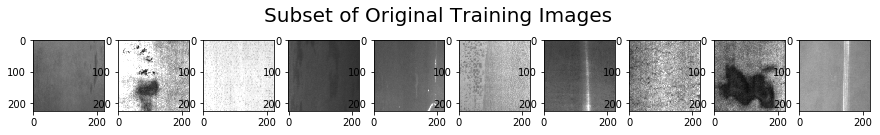

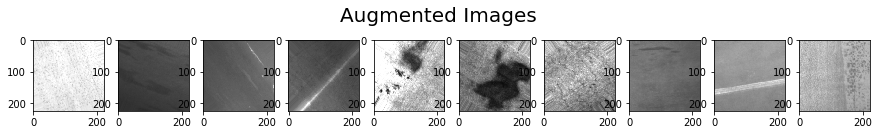

In [13]:
# take subset of training data
no_preview_image = 10
train_tensors_subset = train_tensors[:no_preview_image]

# visualize subset of training data
fig = plt.figure(figsize=(15,2))
for i in range(0, len(train_tensors_subset)):
    ax = fig.add_subplot(1, no_preview_image, i+1)
    ax.imshow(train_tensors_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
# devided by 255: https://blog.csdn.net/aaon22357/article/details/82736792
fig = plt.figure(figsize=(15,2))
for x_batch in datagen_train.flow(train_tensors_subset, batch_size=no_preview_image):
    for i in range(0, no_preview_image):
        ax = fig.add_subplot(1, no_preview_image, i+1)
        #ax.imshow(x_batch[i]/255)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### Histogram Equalization Techniques

https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

# Different type of histogram

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


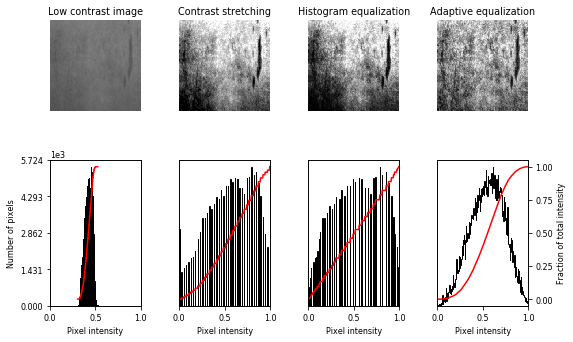

In [14]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


def histogram():
    # Load an example image from cifar10 dataset
    img = train_tensors[0]

    # Set font size for images
    matplotlib.rcParams['font.size'] = 8

    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    # Histogram Equalization
    img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

    #### Everything below here is just to create the plot/graphs ####

    # Display results
    fig = plt.figure(figsize=(8, 5)) 
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()
    
    
histogram()

# Extract the feature files

In [15]:

#INPUT_SCAN_FOLDER='E:\\Udacity\\steelplate-data\\NEU surface defect database\\' # path where the dataset is stored

def preprocess_for_ml():
    slices=[]
    for dirName, subdirList, fileList in os.walk('data'):
            for filename in fileList:
                if ".bmp" in filename.lower():
                    slices.append(cv2.imread(os.path.join(dirName, filename),0))

    print("done")
    proList = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy']
    featlist= ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy','Label']
    properties =np.zeros(5)
    glcmMatrix = []
    final=[]
    
    for i in range(len(slices)):
        img = slices[i]

        # pyplot.imshow((images[k,:,:]),cmap='gray')
        # pyplot.show()
        #  get properties
        glcmMatrix=(greycomatrix(img, [1], [0], levels=256))

       # print(len(glcmMatrix))
        # get properties
        for j in range(0, len(proList)):
            properties[j]=(greycoprops(glcmMatrix, prop=proList[j]))

        label=(i/300)
        features = np.array([properties[0],properties[1],properties[2],properties[3],properties[4],np.floor(label)])
        final.append(features)

    df = pd.DataFrame(final,columns=featlist)
    filepath="features.xlsx"  #path where to save the features
    df.to_excel(filepath)
    
#preprocess_for_ml()

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using accuracy, the coefficient of determination.  


### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

In [17]:
def image_to_feature_vector():
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    rawImages = []
    for dirName, subdirList, fileList in os.walk('data'):
        for filename in fileList:
            if ".bmp" in filename.lower():
                pixels = cv2.resize(cv2.imread(os.path.join(dirName, filename),0), (32, 32)).flatten()
                rawImages.append(pixels)
    
    rawImages = np.array(rawImages)
    return rawImages

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 

[0.41222222 0.55638889 0.56861111 0.57388889 0.57472222 0.58166667
 0.57861111 0.57388889 0.57444444]
[0.53555556 0.70916667 0.73694444 0.74583333 0.75194444 0.74944444
 0.74972222 0.74833333 0.75361111]
[0.52472222 0.74944444 0.77027778 0.79       0.78666667 0.77888889
 0.79083333 0.79027778 0.79583333]
[0.54333333 0.76666667 0.81027778 0.82694444 0.83055556 0.835
 0.84916667 0.86027778 0.85722222]
Decision Tree (max_depth=5) feature testing accuracy= 83.55555555555556
Decision Tree (max_depth=5) raw testing accuracy= 47.333333333333336
--- 0.36060118675231934 seconds ---


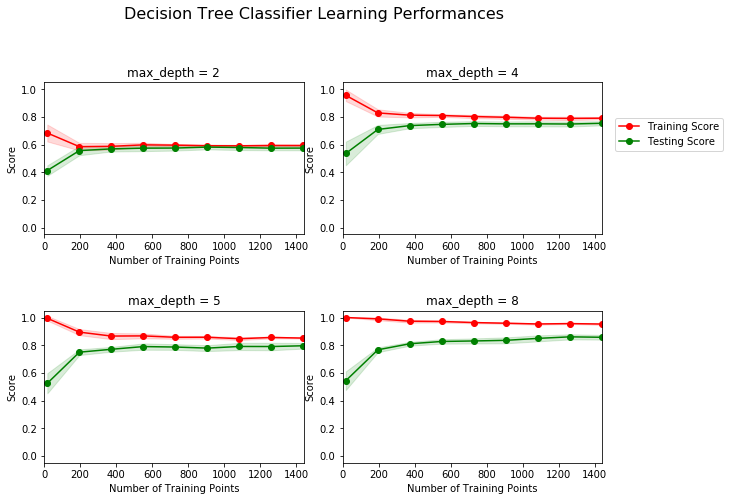

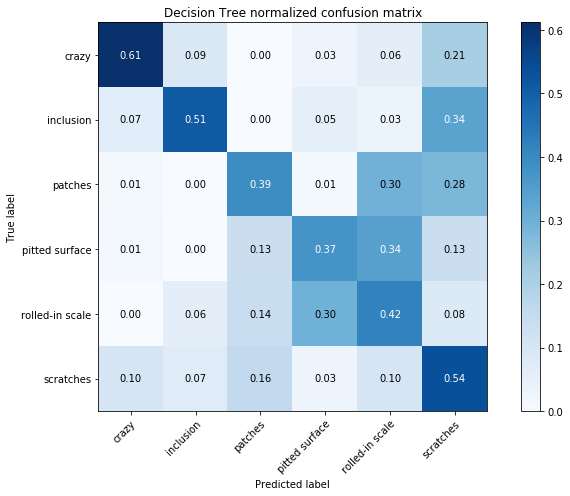

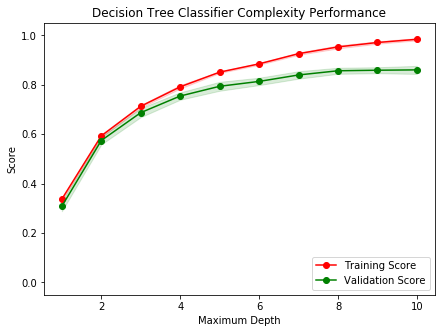

----------------------------------------------------------------------------------------------------
[0.16305556 0.1725     0.16027778 0.15444444 0.16166667 0.16194444
 0.14888889 0.1475     0.14305556]
[0.16305556 0.1725     0.16027778 0.15444444 0.16166667 0.16194444
 0.14888889 0.1475     0.14305556]
[0.16305556 0.1725     0.16027778 0.15444444 0.16166667 0.16194444
 0.14888889 0.1475     0.14305556]
[0.16305556 0.1725     0.16027778 0.15444444 0.16166667 0.16194444
 0.14888889 0.1475     0.14305556]
SVC (C=.53, gamma=10) feature testing accuracy= 14.888888888888888
--- 0.10707616806030273 seconds ---


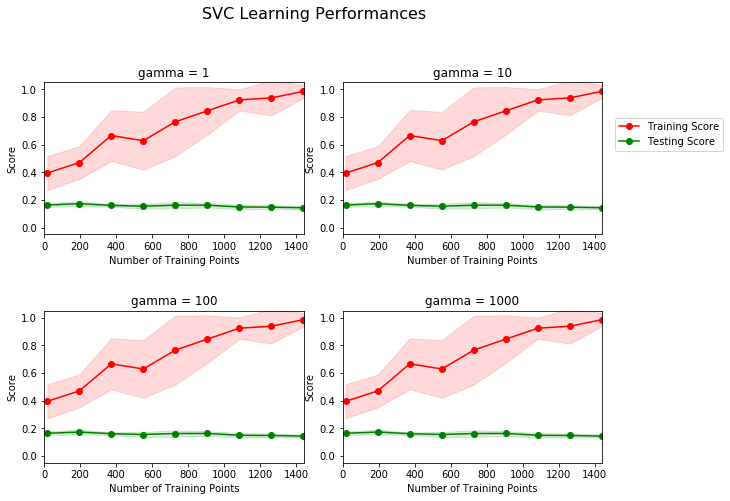

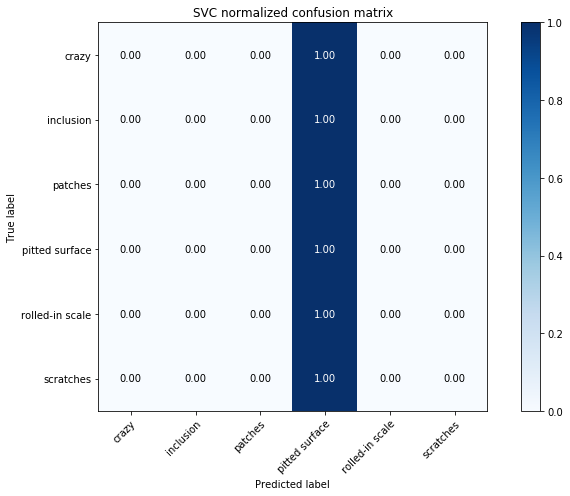

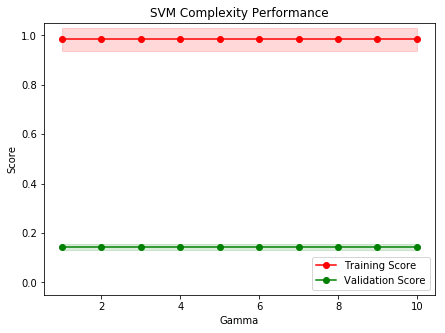

----------------------------------------------------------------------------------------------------
[0.32055556 0.37972222 0.38805556 0.35388889 0.34916667 0.36888889
 0.36611111 0.36944444 0.3925    ]
[0.35611111 0.40333333 0.41083333 0.41055556 0.44111111 0.49416667
 0.49111111 0.49194444 0.48777778]
[0.38833333 0.42111111 0.4475     0.465      0.46805556 0.49333333
 0.48666667 0.48083333 0.48388889]
[0.40805556 0.45111111 0.46527778 0.46333333 0.47472222 0.49111111
 0.48555556 0.47722222 0.48472222]
AdaBoost (max_iter_predict=100) feature testing accuracy= 59.55555555555555
--- 0.14745187759399414 seconds ---


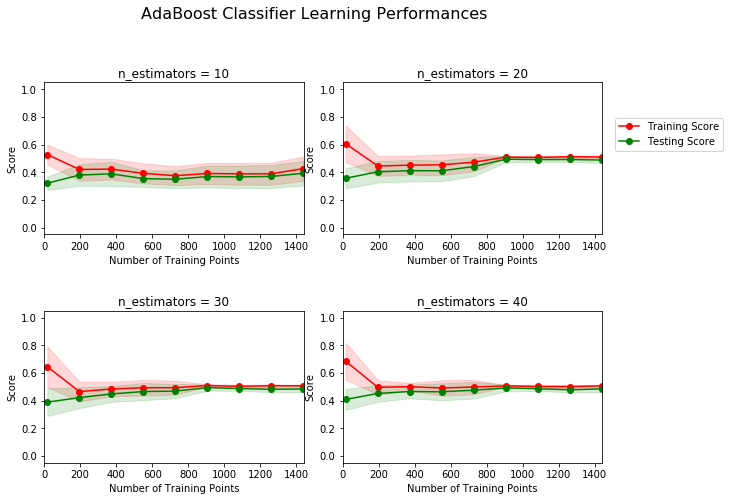

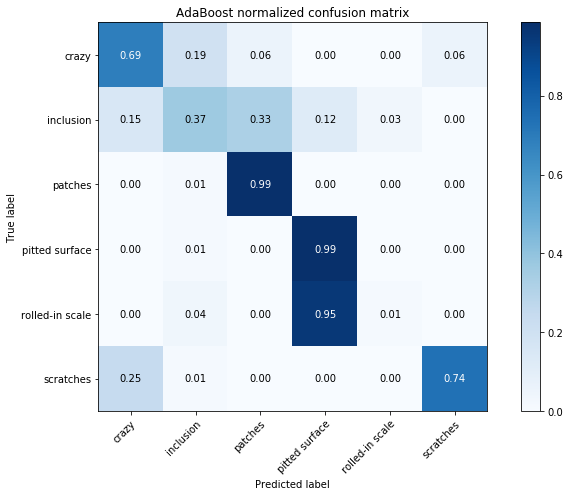

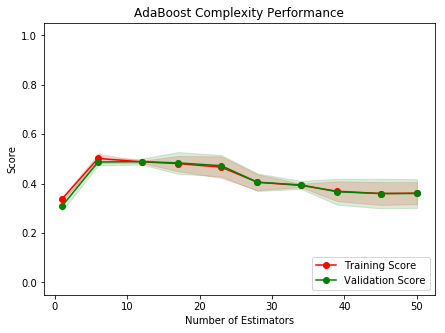

----------------------------------------------------------------------------------------------------
[0.50666667 0.65388889 0.68388889 0.69305556 0.70611111 0.70333333
 0.71361111 0.71722222 0.72277778]
[0.46416667 0.65527778 0.69555556 0.70361111 0.71666667 0.72111111
 0.73083333 0.7375     0.74388889]
[0.38527778 0.64833333 0.67722222 0.70277778 0.71833333 0.72361111
 0.72722222 0.73194444 0.73055556]
[0.31472222 0.64138889 0.68083333 0.68916667 0.70944444 0.72111111
 0.72833333 0.73055556 0.73861111]
KNN (n_neighbors=5) feature testing accuracy= 77.33333333333333
--- 0.0021440982818603516 seconds ---


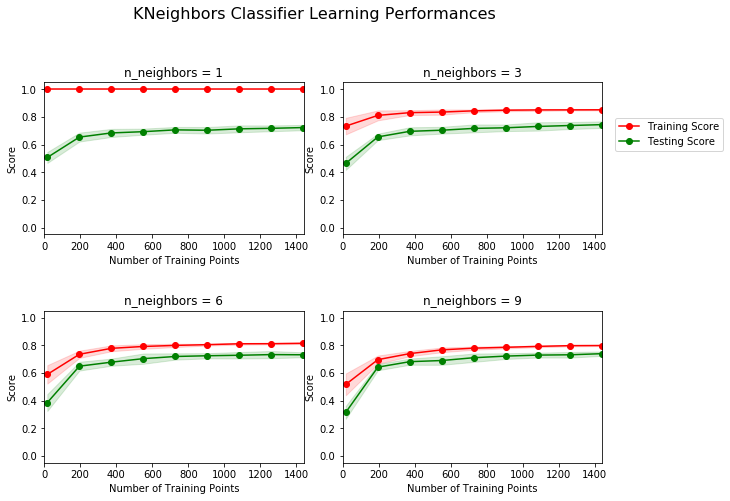

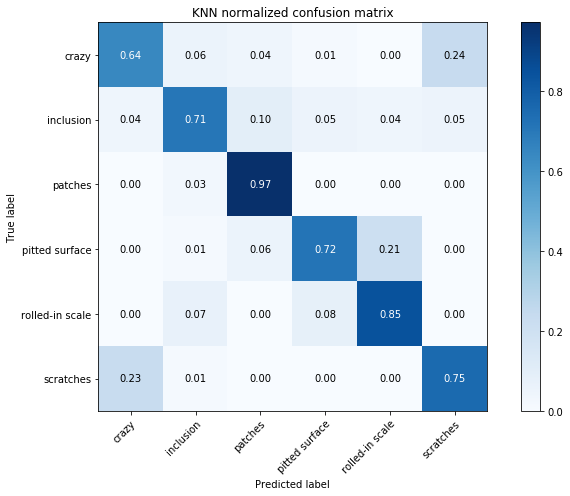

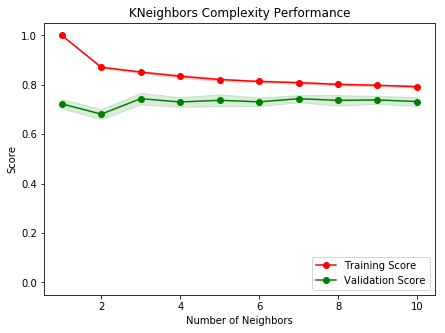

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import time
   
from sklearn.datasets import load_files  
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import AdaBoostClassifier

# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure
from skimage.feature import greycomatrix,greycoprops


from keras.utils import np_utils
from sklearn.utils.multiclass import unique_labels
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import decode_predictions


from keras.callbacks import ModelCheckpoint  
from keras_tqdm import TQDMNotebookCallback
from keras import optimizers
from keras.optimizers import Adam


import matplotlib
import matplotlib.pyplot as plt   

# Import supplementary visualizations code visuals.py
import visuals as vs
from ResNet_CAM import plot_ResNet_CAM, get_ResNet

def image_to_feature_vector():
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    rawImages = []
    for dirName, subdirList, fileList in os.walk('data'):
        for filename in fileList:
            if ".bmp" in filename.lower():
                pixels = cv2.resize(cv2.imread(os.path.join(dirName, filename),0), (32, 32)).flatten()
                rawImages.append(pixels)
    
    rawImages = np.array(rawImages)
    return rawImages






def ml_analysis():
    
    
    path='data/features.xlsx'  #give path where extracted features are saved
    
    excel_content=pd.read_excel(path,header=None)
    X = np.array((excel_content.as_matrix())[1:,1:])
    labels = X[:,5].astype('int')
    features = X[:,0:5]
    rawImages = image_to_feature_vector()
    #trainFeat, testFeat, trainLabels, testLabels = train_test_split(features,labels,test_size=0.25,random_state=42)
    #trainRI, testRI, trainRL, testRL = train_test_split(rawImages, labels, test_size=0.25, random_state=42)
        
    #trainFeat = trainFeat.astype('int')
    #testFeat = testFeat.astype('int')
    #vs.KNeighbors_ModelLearning(trainRI, trainRL)
    #vs.KNeighbors_ModelComplexity(features, labels)
    
    #testt = neigh.predict(testFeat)
    #score_features = accuracy_score(testLabels, testt)
    
    # Raw
    #K_value = 6
    #neigh = KNeighborsClassifier(n_neighbors=K_value, weights='uniform', algorithm='auto')
    #neigh.fit(trainRI, trainRL)
    #testt = neigh.predict(testRI)
    #score_raw = accuracy_score(testLabels, testt)

    #print(np.linspace(0.1, 1.0, 5))    
    #print(np.rint(np.linspace(trainFeat.shape[0]*0.2, trainFeat.shape[0]*0.8 - 1, 9)).astype(int))
    
    # Produce learning curves for varying training set sizes and maximum depths
    # Features
    vs.DecisionTree_ModelLearning(features, labels, rawImages, "Decision Tree")
    vs.DecisionTree_ModelComplexity(features, labels)
    
    print("-"*100)
    vs.SVM_ModelLearning(features, labels, rawImages, "SVC")
    vs.SVM_ModelComplexity(features, labels)
    
    print("-"*100)
    vs.AdaBoost_ModelLearning(features, labels, rawImages, "AdaBoost")
    vs.AdaBoost_ModelComplexity(features, labels)
        
    print("-"*100)
    vs.KNeighbors_ModelLearning(features, labels, rawImages, "KNN")
    vs.KNeighbors_ModelComplexity(features, labels)
    
    
    

ml_analysis()

# GridSearchCV

In [ ]:
def gridSearch():
        
    path='data/features.xlsx'  #give path where extracted features are saved
    
    excel_content=pd.read_excel(path,header=None)
    X = np.array((excel_content.as_matrix())[1:,1:])
    labels = X[:,5].astype('int')
    features = X[:,0:5]
    rawImages = image_to_feature_vector()
    
    vs.gridSearch_tunning(features, labels, rawImages)
    
gridSearch()

In [ ]:
The best parameter for AdaBoostClassifier is {'learning_rate': 0.01, 'n_estimators': 10, 'random_state': 0} with a runtime of 65.05 seconds.
The best parameter for BaggingClassifier is {'max_samples': 1.0, 'n_estimators': 300, 'random_state': 0} with a runtime of 75.93 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300, 'random_state': 0} with a runtime of 112.75 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'random_state': 0} with a runtime of 249.46 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50, 'oob_score': True, 'random_state': 0} with a runtime of 217.96 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 405.77 seconds.
The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.36 seconds.
The best parameter for GaussianNB is {} with a runtime of 0.08 seconds.
The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'distance'} with a runtime of 22.86 seconds.
The best parameter for SVC is {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 231.77 seconds.
Total optimization time was 23.03 minutes.

# Old grid-search

In [ ]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    """
        https://stackoverflow.com/questions/39158003/confused-about-random-state-in-decision-tree-of-scikit-learn
        So, the random algorithm will be used in any case. 
        Passing any value (whether a specific int, e.g., 0, or a RandomState instance),
        will not change that. The only rationale for passing in an int value (0 or otherwise) 
        is to make the outcome consistent across calls: 
        if you call this with random_state=0 (or any other value), 
        then each and every time, you'll get the same result.
    """
    regressor = DecisionTreeRegressor(random_state=10)

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {"max_depth": list(range(1, 11))}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric, params)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:
def optimized_tree_model():
    
    K_value = 6
    
    path='data/features.xlsx'  #give path where extracted features are saved
    
    excel_content=pd.read_excel(path,header=None)

    X = np.array((excel_content.as_matrix())[1:,1:])
    labels = X[:,5].astype('int')
    features = X[:,0:5]
    
    trainFeat, testFeat, trainLabels, testLabels = train_test_split(features,labels,test_size=0.25,random_state=42)
       
    trainFeat = trainFeat.astype('int')
    
    # Fit the training data to the model using grid search
    reg = fit_model(trainFeat, trainLabels)

    # Produce the value for 'max_depth'
    print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

optimized_tree_model()

** Hint: ** The answer comes from the output of the code snipped above.

**Answer: **

The model has an optimal maximum depth of 4. 

The result matches the intuition of Question 6 of Best-Guess Optimal Model above. According to our Complexity Curves section, we know those two lines (training and validate line) start separating after the depth of 4 to get the trade off between score in test and in training sets.

### Deep learning

In [9]:
def benchmark_model():
    
    # parameters for architecture
    input_shape = (224, 224, 3)
    num_classes = 6
    conv_size = 32

    # parameters for training
    batch_size = 32
    epochs = 10

    # build the model
    model = Sequential()

    # The convolution layer has 32  filters with a 3 x 3  kernel. We’re using RELU  the activation function followed by batch normalization.
    model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same', input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    # compile the model
    sgd = optimizers.SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  #optimizer='adam',
                  optimizer=sgd,
                  metrics=['accuracy'])

    model.summary()
    plot_model(model, to_file='model_bm_plot.png', show_shapes=True, show_layer_names=False)
  
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

    # train the model                    
    history = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer, TQDMNotebookCallback()],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)
    
    return model, history 


start_time = time.time()    
bm_model, benchmark_model_history = benchmark_model() 
print("--- %s seconds ---" % (time.time() - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
__________

Epoch 1/10


 - 14s - loss: 1.7224 - acc: 0.2495 - val_loss: 1.5930 - val_acc: 0.3182

Epoch 00001: val_loss improved from inf to 1.59298, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10


 - 14s - loss: 1.5443 - acc: 0.3670 - val_loss: 1.5857 - val_acc: 0.3466

Epoch 00002: val_loss improved from 1.59298 to 1.58569, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10


 - 14s - loss: 1.4314 - acc: 0.4375 - val_loss: 1.2448 - val_acc: 0.5312

Epoch 00003: val_loss improved from 1.58569 to 1.24475, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10


 - 14s - loss: 1.3605 - acc: 0.4864 - val_loss: 1.2078 - val_acc: 0.5568

Epoch 00004: val_loss improved from 1.24475 to 1.20781, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/10


 - 14s - loss: 1.1395 - acc: 0.5649 - val_loss: 1.2411 - val_acc: 0.4915

Epoch 00005: val_loss did not improve from 1.20781
Epoch 6/10


 - 14s - loss: 1.0361 - acc: 0.6110 - val_loss: 0.8565 - val_acc: 0.7131

Epoch 00006: val_loss improved from 1.20781 to 0.85652, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 7/10


 - 15s - loss: 0.9256 - acc: 0.6728 - val_loss: 0.8670 - val_acc: 0.6932

Epoch 00007: val_loss did not improve from 0.85652
Epoch 8/10


 - 16s - loss: 0.9319 - acc: 0.6504 - val_loss: 0.8161 - val_acc: 0.6960

Epoch 00008: val_loss improved from 0.85652 to 0.81608, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 9/10


 - 14s - loss: 0.5486 - acc: 0.8093 - val_loss: 0.9236 - val_acc: 0.7045

Epoch 00009: val_loss did not improve from 0.81608
Epoch 10/10


 - 13s - loss: 0.6727 - acc: 0.7888 - val_loss: 1.1370 - val_acc: 0.6278

Epoch 00010: val_loss did not improve from 0.81608

--- 144.03249049186707 seconds ---


In [13]:
def new_benchmark_model():
    
    # parameters for architecture
    input_shape = (224, 224, 3)
    num_classes = 6
    conv_size = 32

    # parameters for training
    batch_size = 16
    epochs = 10
    learning_rate = 1e-2

    # build the model
    model = Sequential()
    
    model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # softmax classifier
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model
    opt = Adam(lr=learning_rate, decay=learning_rate / (epochs*2))
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    model.summary()
    plot_model(model, to_file='model_new_bm_plot.png', show_shapes=True, show_layer_names=False)
  
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_new.hdf5', 
                               verbose=1, save_best_only=True)

    # train the model                    
    history = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer, TQDMNotebookCallback()],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)
    
    return model, history 

    
start_time = time.time()    
new_bm_model, new_benchmark_model_history = new_benchmark_model()   
print("--- %s seconds ---" % (time.time() - start_time)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 32)        0         
__________

Epoch 1/10


 - 17s - loss: 1.7178 - acc: 0.4300 - val_loss: 1.3928 - val_acc: 0.5341

Epoch 00001: val_loss improved from inf to 1.39276, saving model to saved_models/weights.best.from_scratch_new.hdf5
Epoch 2/10


 - 16s - loss: 1.3954 - acc: 0.4826 - val_loss: 3.6078 - val_acc: 0.2784

Epoch 00002: val_loss did not improve from 1.39276
Epoch 3/10


 - 16s - loss: 1.3103 - acc: 0.4832 - val_loss: 5.7230 - val_acc: 0.2443

Epoch 00003: val_loss did not improve from 1.39276
Epoch 4/10


 - 17s - loss: 1.2312 - acc: 0.5136 - val_loss: 1.7687 - val_acc: 0.3949

Epoch 00004: val_loss did not improve from 1.39276
Epoch 5/10


 - 18s - loss: 1.2245 - acc: 0.5280 - val_loss: 4.3874 - val_acc: 0.2415

Epoch 00005: val_loss did not improve from 1.39276
Epoch 6/10


 - 17s - loss: 1.1543 - acc: 0.5433 - val_loss: 3.3617 - val_acc: 0.2955

Epoch 00006: val_loss did not improve from 1.39276
Epoch 7/10


 - 16s - loss: 1.1512 - acc: 0.5558 - val_loss: 1.7706 - val_acc: 0.5540

Epoch 00007: val_loss did not improve from 1.39276
Epoch 8/10


 - 16s - loss: 1.1435 - acc: 0.5462 - val_loss: 1.7262 - val_acc: 0.4773

Epoch 00008: val_loss did not improve from 1.39276
Epoch 9/10


 - 17s - loss: 1.0939 - acc: 0.5769 - val_loss: 7.0469 - val_acc: 0.1562

Epoch 00009: val_loss did not improve from 1.39276
Epoch 10/10


 - 16s - loss: 1.1668 - acc: 0.5390 - val_loss: 2.7603 - val_acc: 0.3068

Epoch 00010: val_loss did not improve from 1.39276

--- 167.6871485710144 seconds ---


# ResNet

In [14]:
def rest50_model():
    # parameters for architecture
    input_shape = (224, 224, 3)
    num_classes = 6

    # parameters for training
    batch_size = 32
    epochs = 10
    
    learning_rate = 1e-3

    # load Restnet50 from Keras
    # When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, 
    baseModel = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # add custom Layers
    headModel = GlobalAveragePooling2D(input_shape=input_shape)(baseModel.output)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    headModel = Dense(32, activation='relu', kernel_initializer="he_normal")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel= Dropout(0.4)(headModel)
    
    headModel = Dense(16, activation='relu', kernel_initializer="he_normal")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    # 6 different labels
    output = Dense(num_classes, activation='softmax')(headModel)
    
    # define new model
    model = Model(inputs=baseModel.inputs, outputs=output)
    
    # [!!!Important -  freeze all of the CONV layers in the body of ResNet50 !!!!]
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    #model.summary()
    plot_model(model, to_file='model_resNet_plot.png', show_shapes=True, show_layer_names=True)
    
    # for the changes to the model to take affect we need to recompile
    # the model, this time using SGD with a *very* small learning rate
    #sgd = optimizers.SGD(lr=1e-2, momentum=0.9)
    opt = Adam(lr=learning_rate, decay=learning_rate / (epochs*2))
    #model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.rest50.hdf5', 
                               verbose=1, save_best_only=True)

    # train the model       
    history = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer, TQDMNotebookCallback()],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)
    
    return model, history

start_time = time.time()        
rn50_model, rest50_model_history = rest50_model()
print("--- %s seconds ---" % (time.time() - start_time)) 

Epoch 1/10


 - 20s - loss: 1.4446 - acc: 0.4791 - val_loss: 2.1652 - val_acc: 0.1392

Epoch 00001: val_loss improved from inf to 2.16521, saving model to saved_models/weights.best.rest50.hdf5
Epoch 2/10


 - 18s - loss: 0.8754 - acc: 0.6900 - val_loss: 2.8608 - val_acc: 0.1392

Epoch 00002: val_loss did not improve from 2.16521
Epoch 3/10


 - 18s - loss: 0.6726 - acc: 0.7902 - val_loss: 2.7288 - val_acc: 0.1392

Epoch 00003: val_loss did not improve from 2.16521
Epoch 4/10


 - 21s - loss: 0.5946 - acc: 0.8267 - val_loss: 2.8598 - val_acc: 0.1392

Epoch 00004: val_loss did not improve from 2.16521
Epoch 5/10


 - 18s - loss: 0.5143 - acc: 0.8473 - val_loss: 3.0900 - val_acc: 0.1392

Epoch 00005: val_loss did not improve from 2.16521
Epoch 6/10


 - 18s - loss: 0.4488 - acc: 0.8721 - val_loss: 2.9816 - val_acc: 0.1392

Epoch 00006: val_loss did not improve from 2.16521
Epoch 7/10


 - 19s - loss: 0.4629 - acc: 0.8622 - val_loss: 2.8488 - val_acc: 0.1392

Epoch 00007: val_loss did not improve from 2.16521
Epoch 8/10


 - 20s - loss: 0.3498 - acc: 0.9183 - val_loss: 3.1832 - val_acc: 0.1392

Epoch 00008: val_loss did not improve from 2.16521
Epoch 9/10


 - 18s - loss: 0.3425 - acc: 0.9111 - val_loss: 3.1753 - val_acc: 0.1392

Epoch 00009: val_loss did not improve from 2.16521
Epoch 10/10


 - 18s - loss: 0.3436 - acc: 0.9063 - val_loss: 3.0681 - val_acc: 0.1392

Epoch 00010: val_loss did not improve from 2.16521

--- 208.33717560768127 seconds ---


# VGG model

In [10]:
def VGG_model():
    # parameters for architecture
    input_shape = (224, 224, 3)
    num_classes = 6

    # parameters for training
    batch_size = 32
    epochs = 10

    learning_rate = 1e-3
    
    # load Restnet50 from Keras
    # When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, 
    baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # add custom Layers
    headModel = GlobalAveragePooling2D(input_shape=input_shape)(baseModel.output)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    headModel = Dense(64, activation='relu', kernel_initializer="he_normal")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    headModel = Dense(32, activation='relu', kernel_initializer="he_normal")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    # 6 different labels
    output = Dense(num_classes, activation='softmax')(headModel)
    
    # define new model
    model = Model(inputs=baseModel.inputs, outputs=output)
    # [!!!Important -  freeze all of the CONV layers in the body of ResNet50 !!!!]
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    #model.summary()
    plot_model(model, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)
    
    # for the changes to the model to take affect we need to recompile
    # the model, this time using SGD with a *very* small learning rate
    #sgd = optimizers.SGD(lr=1e-2, momentum=0.9)
    opt = Adam(lr=learning_rate, decay=learning_rate / (epochs*2))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

    # train the model       
    history = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer, TQDMNotebookCallback()],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)
    
    return model, history
    
start_time = time.time()    
vgg_model, vgg_model_history = VGG_model()  
print("--- %s seconds ---" % (time.time() - start_time)) 

Epoch 1/10


 - 22s - loss: 2.0550 - acc: 0.3337 - val_loss: 0.8460 - val_acc: 0.7244

Epoch 00001: val_loss improved from inf to 0.84603, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/10


 - 17s - loss: 1.1332 - acc: 0.5723 - val_loss: 0.5626 - val_acc: 0.8125

Epoch 00002: val_loss improved from 0.84603 to 0.56261, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/10


 - 17s - loss: 0.9120 - acc: 0.6623 - val_loss: 0.4550 - val_acc: 0.8295

Epoch 00003: val_loss improved from 0.56261 to 0.45495, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/10


 - 17s - loss: 0.7905 - acc: 0.7059 - val_loss: 0.3877 - val_acc: 0.8693

Epoch 00004: val_loss improved from 0.45495 to 0.38771, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 5/10


 - 18s - loss: 0.7460 - acc: 0.7362 - val_loss: 0.3554 - val_acc: 0.8977

Epoch 00005: val_loss improved from 0.38771 to 0.35543, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 6/10


 - 18s - loss: 0.6466 - acc: 0.7648 - val_loss: 0.3047 - val_acc: 0.9006

Epoch 00006: val_loss improved from 0.35543 to 0.30471, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 7/10


 - 19s - loss: 0.5916 - acc: 0.8013 - val_loss: 0.2569 - val_acc: 0.9290

Epoch 00007: val_loss improved from 0.30471 to 0.25693, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 8/10


 - 19s - loss: 0.5458 - acc: 0.8168 - val_loss: 0.2343 - val_acc: 0.9403

Epoch 00008: val_loss improved from 0.25693 to 0.23429, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 9/10


 - 21s - loss: 0.5321 - acc: 0.8035 - val_loss: 0.1906 - val_acc: 0.9631

Epoch 00009: val_loss improved from 0.23429 to 0.19060, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 10/10


 - 19s - loss: 0.5135 - acc: 0.8242 - val_loss: 0.1739 - val_acc: 0.9659

Epoch 00010: val_loss improved from 0.19060 to 0.17386, saving model to saved_models/weights.best.VGG16.hdf5

--- 189.91738843917847 seconds ---


# Classifiers learning performance

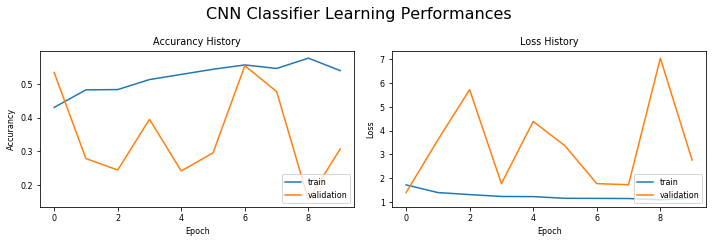

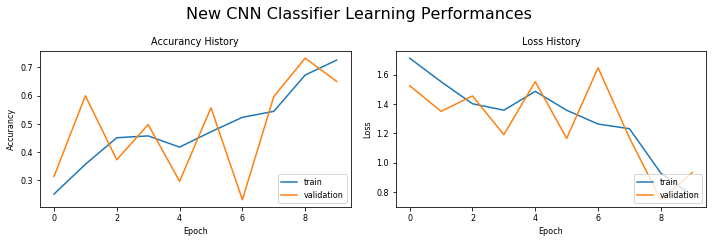

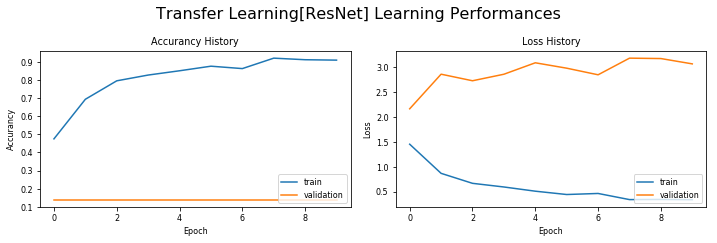

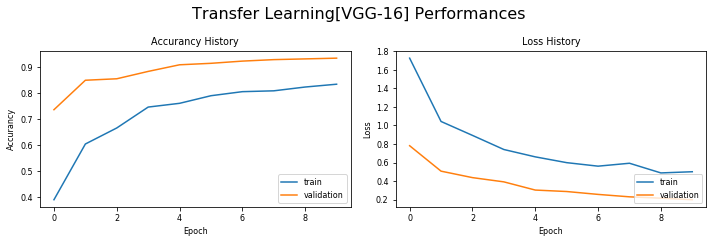

In [16]:
def show_train_history(train_history, sub_title):
    
    fig = plt.figure(figsize=(10,3))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_history.history['acc'])
    ax.plot(train_history.history['val_acc'])
    ax.set_title('Accurancy History')
    ax.set_ylabel('Accurancy')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], loc='lower right')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_history.history['loss'])
    ax.plot(train_history.history['val_loss'])
    ax.set_title('Loss History')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], loc='lower right')
    fig.suptitle(sub_title, fontsize = 16, y = 1.1)
    fig.tight_layout()
    fig.show()

    
show_train_history(new_benchmark_model_history, 'CNN Classifier Learning Performances') #This one is old...
show_train_history(benchmark_model_history, 'New CNN Classifier Learning Performances') #This one is new...
show_train_history(rest50_model_history, 'Transfer Learning[ResNet] Learning Performances')
show_train_history(vgg_model_history, 'Transfer Learning[VGG-16] Performances')

### Load the Model with the Best Validation Loss

In [17]:
new_bm_model.load_weights('saved_models/weights.best.from_scratch_new.hdf5')
bm_model.load_weights('saved_models/weights.best.from_scratch.hdf5')
rn50_model.load_weights('saved_models/weights.best.rest50.hdf5')
vgg_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [18]:
for model in [bm_model, new_bm_model, rn50_model, vgg_model]:

    start_time = time.time()
    
    # get index of predicted dog breed for each image in test set
    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

    # report test accuracy
    model_test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy: %.4f%%' % model_test_accuracy)
    print("--- %s seconds ---" % (time.time() - start_time)) 

Test accuracy: 77.2222%
--- 1.0715689659118652 seconds ---
Test accuracy: 53.3333%
--- 1.5552246570587158 seconds ---
Test accuracy: 15.5556%
--- 5.338611841201782 seconds ---
Test accuracy: 96.1111%
--- 4.248793601989746 seconds ---


# Confusion Matrix

Normalized confusion matrix


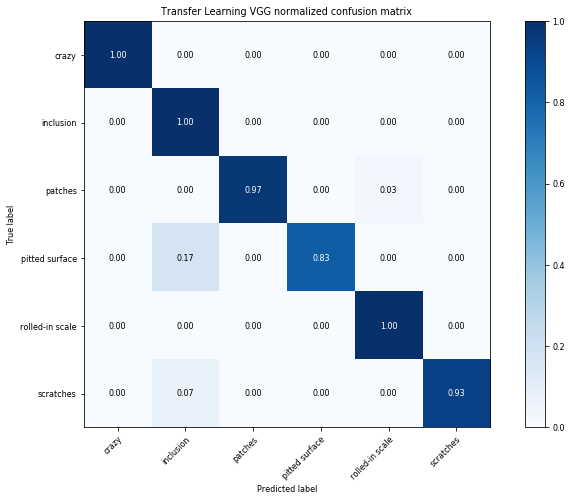

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


'\n'

In [13]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Transfer Learning VGG normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1, 1, 1)
    #fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def preprocess_confusion_matrix(one_hot_test_targets):
    #for model in [bm_model, new_bm_model, rn50_model, vgg_model]:
    for model in [vgg_model]:

        # get index of predicted dog breed for each image in test set
        #model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]
        #print(model_predictions)
        #model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

        class_names = ['crazy', 'inclusion', 'patches', 'pitted surface', 'rolled-in scale', 'scratches']

        #test_pred = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors] 
        test_pred = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]
        test_targets = np.argmax(one_hot_test_targets, axis=1)
        #print(test_targets)
        #print(test_pred)

        np.set_printoptions(precision=4)

        # Plot non-normalized confusion matrix
        #plot_confusion_matrix(test_targets, test_pred, classes=class_names,
        #                      title='Confusion matrix, without normalization')

        # Plot normalized confusion matrix
        plot_confusion_matrix(test_targets, test_pred, classes=class_names, normalize=True)

        plt.show()
        print("-"*200)

preprocess_confusion_matrix(test_targets)
"""
"""

# Heatmap experiment -VGG

(32, 6)
--------------------------------------------------------------------------------
(7, 7, 512)
5
(56, 56, 512)
(32,)


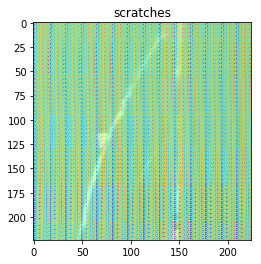

In [4]:
# Import supplementary visualizations code visuals.py
import visuals as vs
from ResNet_CAM import plot_ResNet_CAM, get_ResNet
from keras.applications.vgg16 import VGG16

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization


from keras.models import Sequential, Model

import matplotlib.pyplot as plt   

def get_OurOwnNet():
        # parameters for architecture
    input_shape = (224, 224, 3)
    num_classes = 6

    # parameters for training
    batch_size = 32
    epochs = 10

    learning_rate = 1e-3
    
    # load Restnet50 from Keras
    # When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make predictions is not loaded, 
    baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # add custom Layers
    headModel = GlobalAveragePooling2D(input_shape=input_shape)(baseModel.output)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    headModel = Dense(64, activation='relu', kernel_initializer="he_normal")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    headModel = Dense(32, activation='relu', kernel_initializer="he_normal")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dropout(0.4)(headModel)
    
    # 6 different labels
    output = Dense(num_classes, activation='softmax')(headModel)
    
    # define new model
    model = Model(inputs=baseModel.inputs, outputs=output)
    # [!!!Important -  freeze all of the CONV layers in the body of ResNet50 !!!!]
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    
    model.load_weights('saved_models/weights.best.VGG16.hdf5')    
        

    # get AMP layer weights
    #all_amp_layer_weights = model.layers[-1].get_weights()[0]
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    #print(model.layers[-1])
    print(all_amp_layer_weights.shape)
    #print(len(model.layers[-1].get_weights()))
    #print(model.layers[-1].get_weights()[0])
    print("-"*80)
    
    # extract wanted output
    #OurOwn_model = Model(inputs=model.input, 
    #    outputs=(model.layers[-4].output, model.layers[-1].output)) 
    OurOwn_model = Model(inputs=model.input, 
        outputs=(model.layers[-11].output, model.layers[-1].output)) 
    return OurOwn_model, all_amp_layer_weights

def gen_heatmap():
    
    model, all_amp_layer_weights = get_OurOwnNet()
    fig, ax = plt.subplots()
    CAM = plot_ResNet_CAM('data/steel/sc/Sc_23.bmp', ax, model, all_amp_layer_weights)
    plt.show()  
    

gen_heatmap()

# Heatmap experiment -ResNet only

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

2
[[-0.01490746  0.0113374  -0.05073728 ... -0.02179668 -0.07764222
   0.01018347]
 [-0.00294467  0.00319835  0.01953556 ...  0.03623696  0.00350259
  -0.03321117]
 [-0.01751374  0.00807406  0.00851311 ... -0.03024036  0.05494978
  -0.02511911]
 ...
 [ 0.025289    0.0630148   0.02041481 ... -0.00508354 -0.03542514
  -0.01306196]
 [-0.00623157 -0.01624131 -0.01221174 ...  0.01376359  0.04087579
  -0.0185826 ]
 [-0.02668471  0.0130982  -0.01847764 ...  0.06304929  0.02561448
  -0.00693536]]
(2048,)
--------------------
(7, 7, 2048)
554
(224, 224, 2048)
(2048,)


ValueError: cannot reshape array of size 102760448 into shape (50176,32)

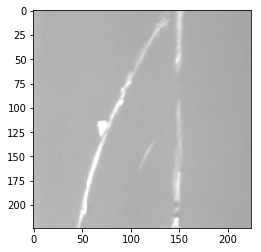

In [1]:
# Import supplementary visualizations code visuals.py
import visuals as vs
from ResNet_CAM import plot_ResNet_CAM, get_ResNet
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization


from keras.models import Sequential, Model

import matplotlib.pyplot as plt   

def get_OurOwnNet():
    # define ResNet50 model
    model = ResNet50(weights='imagenet')
    # get AMP layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    print(len(model.layers[-1].get_weights()))
    print(model.layers[-1].get_weights()[0])
    print("-"*20)
    
    # extract wanted output
    ResNet_model = Model(inputs=model.input,
        outputs=(model.layers[-4].output, model.layers[-1].output))
    return ResNet_model, all_amp_layer_weights

def gen_heatmap():
    
    model, all_amp_layer_weights = get_OurOwnNet()
    fig, ax = plt.subplots()
    CAM = plot_ResNet_CAM('data/steel/sc/Sc_23.bmp', ax, model, all_amp_layer_weights)
    plt.show()  
    

gen_heatmap()

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

(224, 224, 2048)
(2048,)


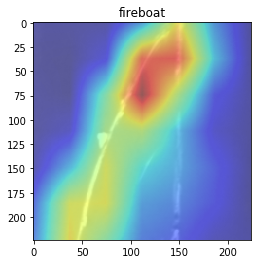

In [1]:
# Import supplementary visualizations code visuals.py
import visuals as vs
from ResNet_CAM import plot_ResNet_CAM, get_ResNet
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization


from keras.models import Sequential, Model

import matplotlib.pyplot as plt   

def get_OurOwnNet():
    # define ResNet50 model
    model = ResNet50(weights='imagenet')
    # get AMP layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    #print(model.layers[-4])
    #print(model.layers[-4].output)
    #print(all_amp_layer_weights.shape)
    
    # extract wanted output
    ResNet_model = Model(inputs=model.input,
        outputs=(model.layers[-4].output, model.layers[-1].output))
    return ResNet_model, all_amp_layer_weights

def gen_heatmap():
    
    model, all_amp_layer_weights = get_OurOwnNet()
    fig, ax = plt.subplots()
    CAM = plot_ResNet_CAM('data/steel/sc/Sc_23.bmp', ax, model, all_amp_layer_weights)
    plt.show()  
    

gen_heatmap()